本案例仅仅用于演示和测试`alphalens`包，策略本身并没有实际意义

In [1]:
%load_ext zipline

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


### 运行策略

In [2]:
%%zipline --start 2018-1-1 --end 2018-5-2 -o result.pkl

import talib
import numpy as np
import math
import logbook

from zipline.api import *
from zipline.pipeline.fundamentals import Fundamentals
from zipline.pipeline import Pipeline
from zipline.pipeline.builtin import TopAverageAmount
from zipline.pipeline.factors import RSI

from zipline.finance import commission, slippage

log = logbook.Logger('RSI')


def make_pipeline():

    return Pipeline(
        columns={
            'rsi': RSI(window_length=15),
            'sector': Fundamentals.info.sector_code.latest,
        },
        # 只选择成交额前500位的股票
        screen=TopAverageAmount(50))


# Setup our variables
def initialize(context):
    # 设置手续费及滑点
    set_commission(commission.PerShare(cost=0))
    set_slippage(slippage.FixedSlippage(spread=0))
    
    context.max_notional = 100000
    context.intc = sid(333)  #symbols(['000333','000002','300017'])
    context.LOW_RSI = 30
    context.HIGH_RSI = 70
    attach_pipeline(make_pipeline(), 'rsi_pipeline')
    schedule_function(rebalance, date_rules.every_day(),
                      time_rules.market_open())


def before_trading_start(context, data):
    #context.output = pipeline_output('rsi_pipeline')
    #print(context.output.head())
    pass

def rebalance(context, data):
    # 接收pipeline输出结果
    output = pipeline_output('rsi_pipeline')

    # Get our current positions
    positions = context.portfolio.positions
    
    # 信号触发可卖出和可买入的股票
    signal_sell = output[output['rsi'] > context.HIGH_RSI].index
    signal_buy = output[output['rsi'] < context.LOW_RSI].index
    
    for s in signal_sell:
        # 存在于持有的头寸中
        if s in positions:
            # 清空头寸
            order_target(s, 0)
            # amount代表持仓数量，而非金额
            current_intel_shares = positions[s].amount
            log.info('RSI is at ' + str(s) + ', 卖出 ' +
                     str(current_intel_shares) + ' shares')
            
    for s in signal_buy:
        # 对于信号提示可买入，但尚未买入的股票，买入固定金额
        if s not in positions:
            o = order_target_value(s, context.max_notional)
            log.info('RSI is at ' + str(s) + ', 买入 ' +
                     str(get_order(o).amount) + ' shares')

    # record the current RSI value and the current price of INTC.
    # record(intcRSI=intc_rsi, intcPRICE=data.current(context.intc, 'close'))

[2018-05-10 00:59:42.245847] INFO: RSI: RSI is at 中国联通(600050), 买入 15527 shares
[2018-05-10 00:59:42.248901] INFO: RSI: RSI is at 三六零(601360), 买入 1977 shares
[2018-05-10 00:59:42.251866] INFO: RSI: RSI is at 中国建筑(601668), 买入 10857 shares
[2018-05-10 00:59:42.267211] INFO: RSI: RSI is at 华友钴业(603799), 买入 1147 shares
[2018-05-10 00:59:42.293594] INFO: RSI: RSI is at 三六零(601360), 卖出 1977 shares
[2018-05-10 00:59:42.308142] INFO: RSI: RSI is at 中环股份(002129), 买入 8865 shares
[2018-05-10 00:59:42.322372] INFO: RSI: RSI is at 华友钴业(603799), 卖出 1147 shares


/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/empyrical-0.4.2-py3.6.egg/empyrical/stats.py:676: RuntimeWarning: invalid value encountered in true_divide
  out=out,
/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/empyrical-0.4.2-py3.6.egg/empyrical/stats.py:762: RuntimeWarning: invalid value encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)
/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/empyrical-0.4.2-py3.6.egg/empyrical/stats.py:762: RuntimeWarning: divide by zero encountered in true_divide
  np.divide(average_annual_return, annualized_downside_risk, out=out)


[2018-05-10 00:59:42.882086] INFO: RSI: RSI is at 上海贝岭(600171), 买入 6285 shares
[2018-05-10 00:59:42.884138] INFO: RSI: RSI is at 中国太保(601601), 买入 2581 shares
[2018-05-10 00:59:42.948066] INFO: RSI: RSI is at 赣锋锂业(002460), 买入 1690 shares
[2018-05-10 00:59:42.949705] INFO: RSI: RSI is at 华能水电(600025), 买入 19801 shares
[2018-05-10 00:59:42.964593] INFO: RSI: RSI is at 中国建筑(601668), 卖出 10857 shares
[2018-05-10 00:59:42.967528] INFO: RSI: RSI is at 紫光国微(002049), 买入 2526 shares
[2018-05-10 00:59:42.998965] INFO: RSI: RSI is at 新华保险(601336), 买入 1631 shares
[2018-05-10 00:59:43.014566] INFO: RSI: RSI is at 南方航空(600029), 买入 9451 shares
[2018-05-10 00:59:43.059788] INFO: RSI: RSI is at 深南电路(002916), 买入 1229 shares
[2018-05-10 00:59:43.062631] INFO: RSI: RSI is at 士兰微(600460), 买入 7178 shares
[2018-05-10 00:59:43.101852] INFO: RSI: RSI is at 亨通光电(600487), 买入 2775 shares
[2018-05-10 00:59:43.119440] INFO: RSI: RSI is at 中兴通讯(000063), 买入 3570 shares
[2018-05-10 00:59:43.122134] INFO: RSI: RSI is at 科

,algo_volatility,algorithm_period_return,alpha,benchmark_period_return,benchmark_volatility,beta,capital_used,ending_cash,ending_exposure,ending_value,...,short_exposure,short_value,shorts_count,sortino,starting_cash,starting_exposure,starting_value,trading_days,transactions,treasury_period_return
2018-01-02 07:00:00+00:00,NaN,0.000000,NaN,0.014028,NaN,NaN,0.00,1.000000e+07,0.000,0.000,...,0.0,0.0,0,NaN,1.000000e+07,0.000,0.000,1,[],0.0
2018-01-03 07:00:00+00:00,0.000000,0.000000,0.000000,0.019980,0.091573,0.000000,-314112.95,9.685887e+06,314112.950,314112.950,...,0.0,0.0,0,NaN,1.000000e+07,0.000,0.000,2,"[{'amount': 15527, 'dt': 2018-01-03 07:00:00+0...",0.0
2018-01-04 07:00:00+00:00,0.009392,0.001025,0.229842,0.024302,0.083268,-0.070913,-102989.13,9.582898e+06,427349.380,427349.380,...,0.0,0.0,0,NaN,9.685887e+06,314112.950,314112.950,3,"[{'amount': 1147, 'dt': 2018-01-04 07:00:00+00...",0.0
2018-01-05 07:00:00+00:00,0.010668,0.000431,0.026166,0.026767,0.081394,0.000623,0.00,9.582898e+06,421414.630,421414.630,...,0.0,0.0,0,5.781735,9.582898e+06,427349.380,427349.380,4,[],0.0
2018-01-08 07:00:00+00:00,0.009244,0.000582,0.029400,0.032079,0.071249,-0.000015,105492.72,9.688391e+06,317432.510,317432.510,...,0.0,0.0,0,6.979430,9.582898e+06,421414.630,421414.630,5,"[{'amount': -1977, 'dt': 2018-01-08 07:00:00+0...",0.0
2018-01-09 07:00:00+00:00,0.008654,0.000304,0.017199,0.039308,0.063871,-0.002699,-100351.80,9.588039e+06,415003.900,415003.900,...,0.0,0.0,0,3.018647,9.688391e+06,317432.510,317432.510,6,"[{'amount': 8865, 'dt': 2018-01-09 07:00:00+00...",0.0
2018-01-10 07:00:00+00:00,0.008641,-0.000228,-0.022858,0.043901,0.059569,0.009445,105879.57,9.693918e+06,303798.130,303798.130,...,0.0,0.0,0,-1.617286,9.588039e+06,415003.900,415003.900,7,"[{'amount': -1147, 'dt': 2018-01-10 07:00:00+0...",0.0
2018-01-11 07:00:00+00:00,0.008001,-0.000236,-0.014534,0.043349,0.066724,0.005299,-200020.32,9.493898e+06,503737.190,503737.190,...,0.0,0.0,0,-1.566814,9.693918e+06,303798.130,303798.130,8,"[{'amount': 6285, 'dt': 2018-01-11 07:00:00+00...",0.0
2018-01-12 07:00:00+00:00,0.007818,-0.000693,-0.029244,0.048165,0.062527,0.007454,0.00,9.493898e+06,499170.080,499170.080,...,0.0,0.0,0,-3.817949,9.493898e+06,503737.190,503737.190,9,[],0.0
2018-01-15 07:00:00+00:00,0.008149,-0.001462,-0.070221,0.048224,0.064455,0.028027,0.00,9.493898e+06,491485.780,491485.780,...,0.0,0.0,0,-5.965558,9.493898e+06,499170.080,499170.080,10,[],0.0


### 投资组合分析

In [3]:
import pyfolio as pf
import pandas as pd
#import empyrical as ep

WARNING (theano.configdefaults): install mkl with `conda install mkl-service`: libmkl_rt.so: cannot open shared object file: No such file or directory
WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


#### 提取指标

In [4]:
results = pd.read_pickle('result.pkl')
returns, positions, transactions = pf.utils.extract_rets_pos_txn_from_zipline(results)

#### 单图例子
绘制排名前5位的回撤周期

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


Text(0.5,0,'日期')

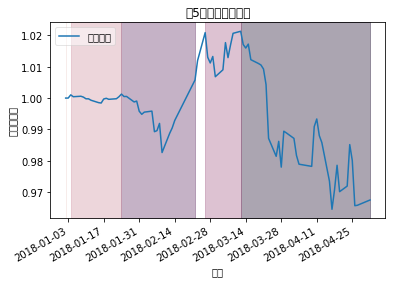

In [5]:
# tearsheet才可以正常显示中文
pf.plot_drawdown_periods(returns, top=5).set_xlabel('日期')

#### 完整`tear sheet`(工作底稿)示例
为算法创建一个完整的工作表。例如，将实时开始日期设置为任意值。

**一般而言，`live_start_date`应设置接近回测结束日期**

/home/ldf/anaconda3/envs/zipline/lib/python3.6/site-packages/numpy/core/fromnumeric.py:52: FutureWarning: 'argmin' is deprecated. Use 'idxmin' instead. The behavior of 'argmin' will be corrected to return the positional minimum in the future. Use 'series.values.argmin' to get the position of the minimum now.
  return getattr(obj, method)(*args, **kwds)


最差回撤,净回撤百分比,波峰日期,波谷日期,回本日期,持续天数
0,5.55,2018-03-12,2018-04-17,NaT,NaN
1,1.86,2018-01-24,2018-02-09,2018-02-22,22
2,1.38,2018-02-26,2018-03-02,2018-03-12,11
3,0.26,2018-01-04,2018-01-16,2018-01-24,15
4,0.00,2018-01-02,2018-01-02,2018-01-02,1


KeyError: "DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',\n               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',\n               '2018-01-12', '2018-01-15', '2018-01-16', '2018-01-17',\n               '2018-01-18', '2018-01-19', '2018-01-22', '2018-01-23',\n               '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-29',\n               '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02',\n               '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08',\n               '2018-02-09', '2018-02-12', '2018-02-13', '2018-02-14',\n               '2018-02-22', '2018-02-23', '2018-02-26', '2018-02-27',\n               '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-05',\n               '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09',\n               '2018-03-12', '2018-03-13', '2018-03-14', '2018-03-15',\n               '2018-03-16', '2018-03-19', '2018-03-20', '2018-03-21',\n               '2018-03-22', '2018-03-23', '2018-03-26', '2018-03-27',\n               '2018-03-28', '2018-03-29', '2018-03-30', '2018-04-02',\n               '2018-04-03', '2018-04-04', '2018-04-09', '2018-04-10',\n               '2018-04-11', '2018-04-12', '2018-04-13', '2018-04-16',\n               '2018-04-17', '2018-04-18', '2018-04-19', '2018-04-20',\n               '2018-04-23', '2018-04-24', '2018-04-25', '2018-04-26',\n               '2018-04-27', '2018-05-02'],\n              dtype='datetime64[ns, UTC]', freq=None) not in index"

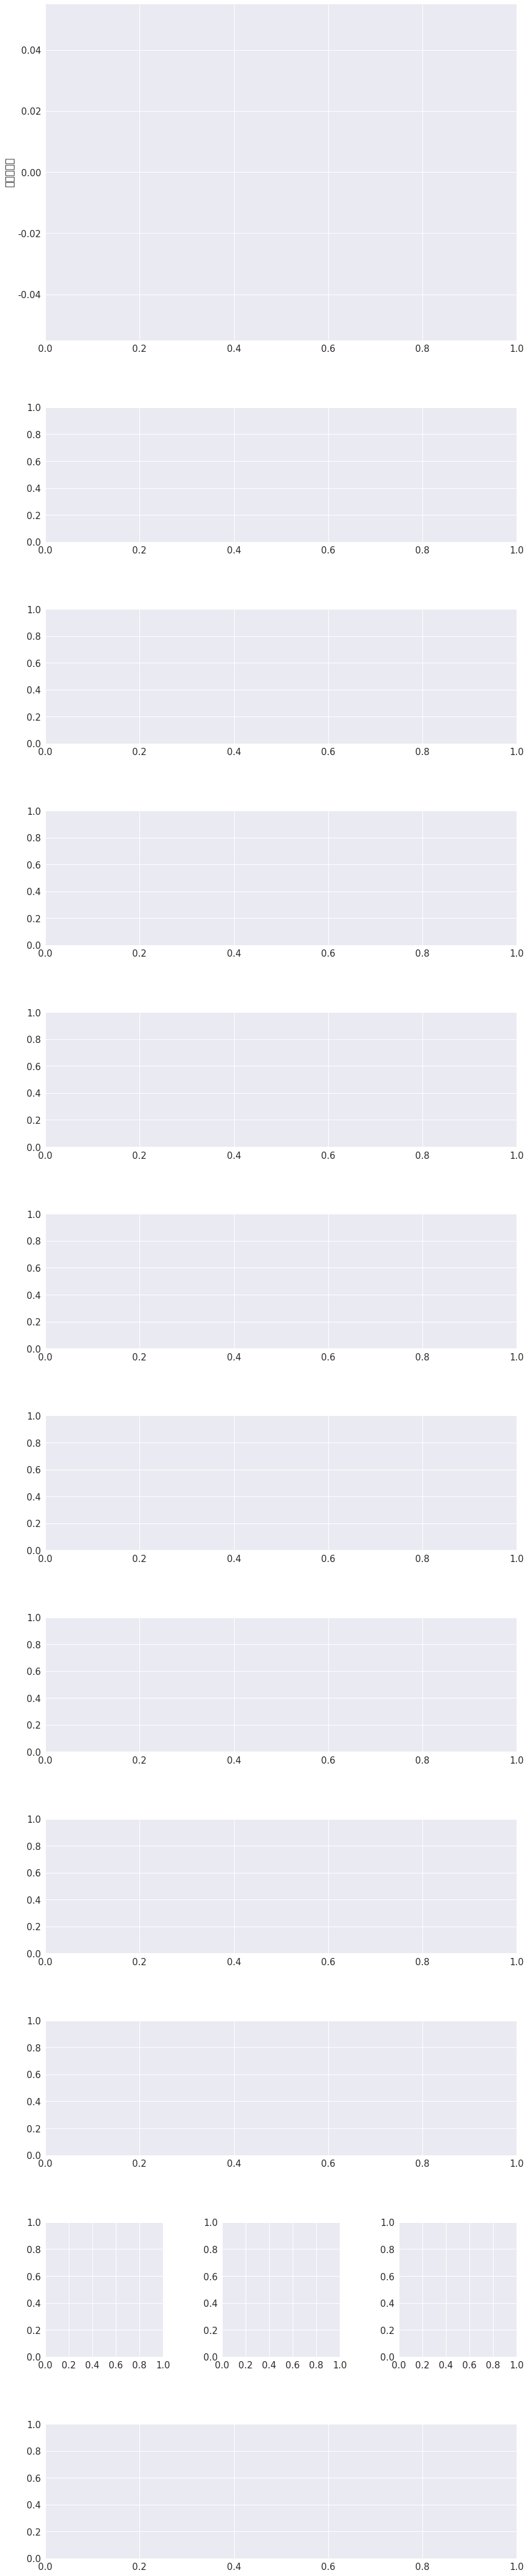

In [6]:
pf.create_full_tear_sheet(returns, positions=positions, transactions=transactions,
                          live_start_date='2018-04-10', round_trips=True)

In [11]:
returns.index

DatetimeIndex(['2018-01-02', '2018-01-03', '2018-01-04', '2018-01-05',
               '2018-01-08', '2018-01-09', '2018-01-10', '2018-01-11',
               '2018-01-12', '2018-01-15', '2018-01-16', '2018-01-17',
               '2018-01-18', '2018-01-19', '2018-01-22', '2018-01-23',
               '2018-01-24', '2018-01-25', '2018-01-26', '2018-01-29',
               '2018-01-30', '2018-01-31', '2018-02-01', '2018-02-02',
               '2018-02-05', '2018-02-06', '2018-02-07', '2018-02-08',
               '2018-02-09', '2018-02-12', '2018-02-13', '2018-02-14',
               '2018-02-22', '2018-02-23', '2018-02-26', '2018-02-27',
               '2018-02-28', '2018-03-01', '2018-03-02', '2018-03-05',
               '2018-03-06', '2018-03-07', '2018-03-08', '2018-03-09',
               '2018-03-12', '2018-03-13', '2018-03-14', '2018-03-15',
               '2018-03-16', '2018-03-19', '2018-03-20', '2018-03-21',
               '2018-03-22', '2018-03-23', '2018-03-26', '2018-03-27',
      

### 整理及补充数据

#### 使用研究模块提取数据
+ 如果存在分红派息，自动调整期间股价
+ 必须与回测期间相同

from zipline.research import run_pipeline

from zipline.pipeline.fundamentals import Fundamentals
from zipline.pipeline import Pipeline
from zipline.pipeline.data import USEquityPricing
from zipline.pipeline.builtin import TopAverageAmount

def make_pipeline():

    return Pipeline(
        columns={
            'close': USEquityPricing.close.latest,
            'sector': Fundamentals.info.sector_code.latest,
        },
        # 只选择成交额前500位的股票
        screen=TopAverageAmount(500))

pipe_output = run_pipeline(make_pipeline(), '2018-1-1', '2018-5-2')

#### 整理数据

# 价格数据必须转换为日期为Index,stock为列名称的宽表
prices = pipe_output.unstack()['close']

prices.head()

factors = pipe_output['sector']
# 行业分类因子期间内不会改变，类型为整数
factors.fillna(method='bfill',inplace=True)
factors.fillna(method='ffill',inplace=True)
factors = factors.astype('int64')

factors.head()

### 因子分析

In [ ]:
from alphalens.utils import get_clean_factor_and_forward_returns

In [ ]:
get_clean_factor_and_forward_returns(factor=factors, prices=prices,max_loss=0)